# NVAE Experiment on CIFAR-10

This notebook implements the training and evaluation pipeline for the Nouveau VAE (NVAE) model on CIFAR-10.

## 1. Google Colab Setup
Mount Drive and clone the repository (Fresh Copy).

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Generative-Modeling-on-CIFAR-10'
REPO_URL = "https://github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

# 1. Delete repo if it already exists (Ensure fresh code)
if os.path.exists(REPO_PATH):
    print(f"Deleting existing repository at {REPO_PATH}...")
    shutil.rmtree(REPO_PATH)

# 2. Clone repository
os.chdir('/content/drive/MyDrive')
print(f"Cloning repository to {REPO_PATH}...")
!git clone {REPO_URL}

# 3. Enter the repository
os.chdir(REPO_PATH)
print(f"Current working directory: {os.getcwd()}")

# 4. Add source code to Python path
sys.path.append(os.path.join(REPO_PATH, 'src'))

Mounted at /content/drive
Deleting existing repository at /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning repository to /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning into 'Generative-Modeling-on-CIFAR-10'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 159 (delta 75), reused 81 (delta 35), pack-reused 33 (from 1)
Receiving objects: 100% (159/159), 213.71 MiB | 19.07 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Updating files: 100% (33/33), done.
Current working directory: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10


## 2. GitHub Configuration (Optional)
Configure this if you want to push results back to the repo.

In [3]:
# GitHub Configuration & Setup
import os

try:
    # 1. Configure Git
    user_name = "konstantine25b"
    mail = "konstantine25b@gmail.com"

    # --- IMPORTANT: PASTE YOUR TOKEN BELOW ---
    my_token = "YOUR_TOKEN_HERE"

    if my_token == "YOUR_TOKEN_HERE":
        print("⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.")

    repo_url = f"https://{my_token}@github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

    !git config --global user.name "{user_name}"
    !git config --global user.email "{mail}"

    # 2. Set Remote URL
    if os.path.isdir(".git") and my_token != "YOUR_TOKEN_HERE":
        !git remote set-url origin "{repo_url}"
        print("Git configured successfully for pushing.")
    else:
        print("Skipping remote setup (either not a git repo or token not set).")

except Exception as e:
    print(f"Error setting up GitHub: {e}")

⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.
Skipping remote setup (either not a git repo or token not set).


## 3. Install Dependencies

In [4]:
!pip install -r requirements.txt
!pip install wandb -q

import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 4. Setup Experiment

In [5]:
import torch
from src.utils.data_loader import get_cifar10_loaders
from src.vae.train import train_vae
from src.vae.sampling import generate_samples, save_sample_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb

# Configuration
config = {
    'epochs': 50,
    'batch_size': 64,
    'lr': 1e-3,
    'hidden_dim': 64,
    'latent_dim': 20,
    'num_scales': 2,
    'warmup_epochs': 5,
    'weight_decay': 3e-4,
    'use_wandb': True, # Set to True if using WandB
    # Save checkpoints OUTSIDE the repo folder to avoid deletion during re-runs
    'model_save_dir': '/content/drive/MyDrive/Generative-Modeling-on-CIFAR-10-Checkpoints/nvae_exp1',
    'results_dir': 'results/'
}

# Create directories
os.makedirs(config['model_save_dir'], exist_ok=True)
os.makedirs(config['results_dir'], exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Checkpoints will be saved to: {config['model_save_dir']}")

Using device: cuda
Checkpoints will be saved to: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10-Checkpoints/nvae_exp1


## 5. Load Data

In [6]:
train_loader, val_loader, test_loader = get_cifar10_loaders(
    data_dir='./data',
    batch_size=config['batch_size']
)

Data Loaders ready: Train=45000, Val=5000, Test=10000


## 6. Train Model

In [7]:
# Start Training
train_vae(config, train_loader, val_loader, device)

Model initialized on cuda
Resuming from checkpoint: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10-Checkpoints/nvae_exp1/nvae_epoch_50.pth
Resumed training from epoch 50


## 7. Final Evaluation on Test Set

In [8]:
from src.vae.train import evaluate, evaluate_with_importance_sampling
from src.vae.model import NVAE

# 1. Load the best model
best_model = NVAE(
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    num_scales=config['num_scales']
).to(device)

best_model_path = os.path.join(config['model_save_dir'], 'nvae_best.pth')
best_model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# 2. Standard Evaluation (ELBO)
test_loss, test_bpd = evaluate(best_model, test_loader, device)
print(f"Standard Test Set Results (ELBO) -> Loss: {test_loss:.4f} | BPD: {test_bpd:.4f}")

# 3. Importance Weighted Evaluation (Tighter Bound, Slower)
# k=100 provides a good balance between speed and accuracy for debugging
# Paper uses k=1000
iw_loss, iw_bpd = evaluate_with_importance_sampling(best_model, test_loader, device, k=100)
print(f"Importance Weighted Results (k=100) -> Loss: {iw_loss:.4f} | BPD: {iw_bpd:.4f}")

# 4. Log to WandB
if wandb.run is not None:
    wandb.log({
        "test/final_loss": test_loss,
        "test/final_bpd": test_bpd,
        "test/iwelbo_loss": iw_loss,
        "test/iwelbo_bpd": iw_bpd
    })
    print("Logged test results to WandB.")

Loaded best model from /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10-Checkpoints/nvae_exp1/nvae_best.pth
Standard Test Set Results (ELBO) -> Loss: 9780.5884 | BPD: 4.5932
Starting Importance Weighted Evaluation (k=100)...


IWELBO Eval: 100%|██████████| 157/157 [11:36<00:00,  4.44s/it]

Importance Weighted Results (k=100) -> Loss: 9673.9916 | BPD: 4.5432
Logged test results to WandB.


## 8. Generate Samples & Log to WandB

Loaded best model.


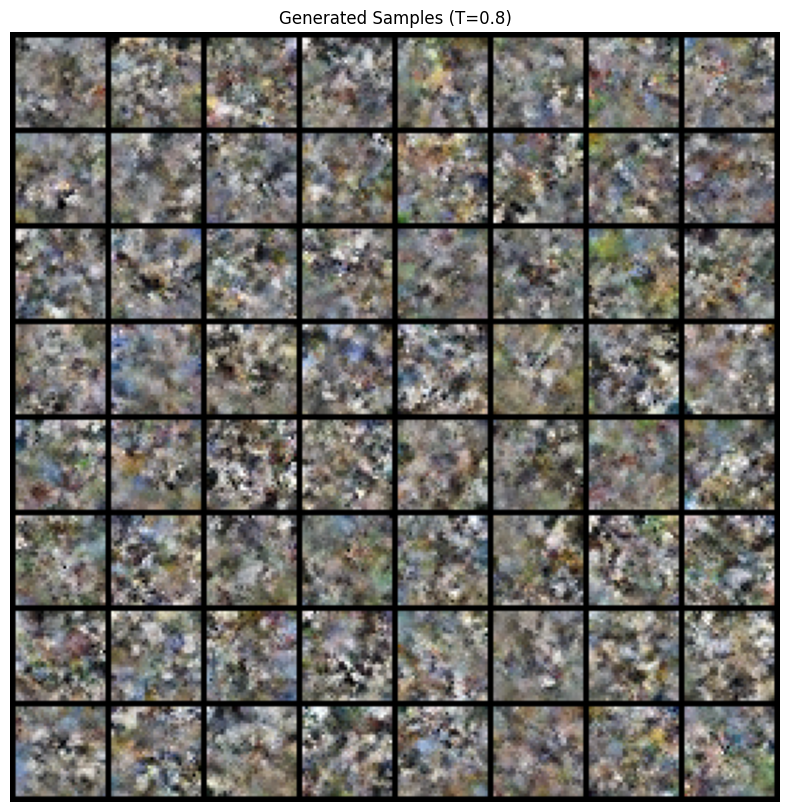

Logged final samples to WandB.


In [9]:
# Load best model (automatically saved during training)
from src.vae.model import NVAE
import torchvision.utils as vutils

model = NVAE(
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    num_scales=config['num_scales']
).to(device)

model.load_state_dict(torch.load(os.path.join(config['model_save_dir'], 'nvae_best.pth')))
print("Loaded best model.")

# Generate
samples = generate_samples(model, num_samples=64, temperature=0.8, device=device)

# Visualize locally
plt.figure(figsize=(10, 10))
grid_img = vutils.make_grid(samples, nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Generated Samples (T=0.8)")
plt.show()

# Log to WandB if active
if wandb.run is not None:
    wandb.log({
        "final_evaluation/generated_samples_grid": [wandb.Image(grid_img, caption="Final Generated Samples (T=0.8)")]
    })
    print("Logged final samples to WandB.")